# Financial News Release Classification

This is a natural language processing, multi-class, text classification project on financial news data. The project will test 3 machine learning algorithms (AdaBoost, Logistic Regression and Support Vector Machines) to classify financial news release titles into 5 different categories (financial release, earnings announcement, acquisition, dividend, dividend increase and misc). 

The goal of this project is to improve the ease and efficiency of reading through financial news releases. Financial analysts and investors use news releases to stay informed and make assessments regarding a company's future financial performance and investment return potential. In any given day, thousands of news releases can be distributed with only a small portion containing useful information. Classifying news releases saves time and improves outcomes by filtering noise and focusing attention on important information. Classification can also be the first step before additional ML and NLP technique are applied, including text summarization, sentiment analysis and information extraction. 

The dataset was personally created by me for the purpose of researching NLP techniques on financial news and related data. I created this dataset by web scraping new release headlines from various public RSS feeds of news release providers. I then personally annotated each sample as belonging to 1 of 6 different classes. 

The categories Financials, Increased Dividend and Acquisition contain information which can be relevant to the future financial and investment performance of a company. The categories Dividend, Earnings Announcement and Misc, generally contain information which is already known or not relevant to future performance.


| Category             | Description                                                       | Important Information |   
|----------------------|-------------------------------------------------------------------|-----------------------|
|Financials            | Quarter and annual financial reporting and outlook.               |         Yes           |
|Increased Dividend    | Dividend or distribution increase annoucement.                    |         Yes           |
|Acquisition           | Acquisition or major asset purchase annoucement.                  |         Yes           |
|Dividend              | Declaration of existing, regular dividend.                        |          No           |
|Earnings Announcement | Announcement of financial results to be released at future date.  |          No           |
|Misc                  | Lawsuits, conferences, management changes, regulatory, etc.       |          No           |

                    

In [1]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import re
import calendar
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Load and Inspect Data 

In [2]:
data = pd.read_csv('data.csv', encoding_errors='ignore')

In [3]:
data.head()

,Category,Title
0,Acquisition,indie Semiconductor Enters Definitive Agreemen...
1,Misc,Virtuoso Acquisition Corp. Announces Effective...
2,Acquisition,Dawson Geophysical Announces Merger Agreement ...
3,Acquisition,Hydrofarm Signs Agreement to Acquire Innovativ...
4,Acquisition,Crestwood to Acquire Oasis Midstream Partners ...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11896 entries, 0 to 11895
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  11896 non-null  object
 1   Title     11896 non-null  object
dtypes: object(2)
memory usage: 186.0+ KB


The dataset contains 11896 samples with zero null values. There are two columns which both contain str data. 

In [5]:
#View category/class counts.
data.groupby('Category').count()

,Title
Category,
Acquisition,151
Dividends,314
Earnings Announcement,961
Financials,1458
Increased Dividend,99
Misc,8913


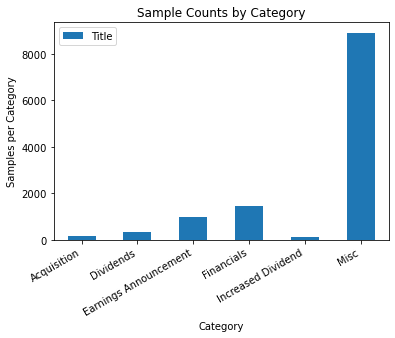

In [6]:
#Bar chart of class counts.
data.groupby('Category').count().plot(kind='bar', title='Sample Counts by Category')
plt.ylabel("Samples per Category")
plt.xticks(rotation=30, horizontalalignment="right")
plt.show()

The category column contains 6 different possible values. There is a substantial class imbalance in the categories which will need to be addressed for classification and validation. 

## Exploratory Data Analysis  

### View Random Samples for Each Category 

The view_samples function below will display a specified (n) number of samples from a specified category. Inspecting individual samples from each category helps to build knowledge of the type of information contained in the samples and how the categories may differ.

In [7]:
#Function to view n numbers of samples per class. 
def view_samples(category, num_samples=5):
    """Category is a str and can be any value from the Category column of the dataset.
       num_samples is an int and specifies the number of random samples to view from the specified Category.
    """
    
    sample_data = data[data.Category == category].sample(num_samples).Title.values
    
    for sample in sample_data:
        print(sample)
        print()
        
    return
    

In [8]:
#View random samples from any category to gain an understanding of the data.
view_samples('Earnings Announcement', num_samples=10)

Masimo to Report Fourth Quarter and Full Year 2020 Financial Results after Market Close on Tuesday, February 23

Plug Power to Announce 2020 Fourth Quarter and Year End Results

LiveXLive Media to Announce Third Quarter Fiscal 2021 Financial Results on Thursday, February 11th

Ambarella Announces Fourth Quarter and Fiscal Year 2021 Earnings Conference Call to be Held March 2, 2021

ACV to Report Third Quarter 2021 Financial Results on November 10, 2021

Novanta Inc. Schedules Earnings Release and Conference Call for Monday, March 01, 2021

SBA Communications Corporation Sets Date for Fourth Quarter 2020 Earnings Release

Mr. Cooper Group Inc. to Discuss Fourth Quarter 2020 Financial Results on February 23, 2021

Ekso Bionics® to Report Fourth Quarter and Full Year 2020 Financial Results on February 25, 2021

Ramaco Resources, Inc. to Release Fourth Quarter 2020 Financial Results on Thursday, February 18, 2021 and Host Conference Call and Webcast on Friday, February 19, 2021



### Explore Length of Text per Sample 

In [9]:
#Tokenize text data.
data['tokenized_text'] = data.Title.apply(lambda x: word_tokenize(x))

In [10]:
#Compute average number of tokens per sample.
data['text_length'] = data.tokenized_text.apply(lambda x: len(x))
data.text_length.describe()

count    11896.000000
mean        15.588685
std          7.818068
min          2.000000
25%         10.000000
50%         14.000000
75%         19.000000
max         60.000000
Name: text_length, dtype: float64

The average number of tokens (including words, symbols, numbers and punctuation) is approximately 16 per sample. The shortest sample has 2 tokens and the largest longest sample has 60 tokens. The interquartile range is between 10 and 19 tokens per sample. 

In [11]:
#Average number of tokens by category.
data.groupby('Category').text_length.mean()

Category
Acquisition              12.834437
Dividends                 9.124204
Earnings Announcement    15.323621
Financials               11.882716
Increased Dividend       11.909091
Misc                     16.538764
Name: text_length, dtype: float64

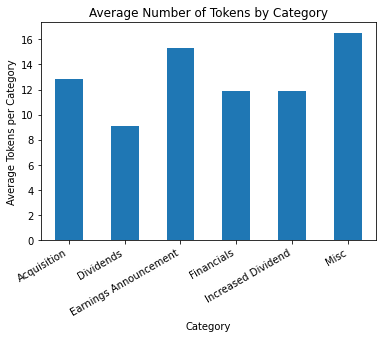

In [12]:
#Bar chart for average tokens per Category.
data.groupby('Category').text_length.mean().plot(kind='bar', title='Average Number of Tokens by Category')
plt.ylabel("Average Tokens per Category")
plt.xticks(rotation=30, horizontalalignment="right")
plt.show()

There does not appear to be a significant difference in the number average number of words between most of the Categories.

### Explore Special Tokens (Symbols, Punctuation and Numbers) 

In [13]:
#Create column for special tokens (includes symbols, puncuation and numbers).
data['special_tokens'] = data.tokenized_text.apply(lambda x: [token for token in x if not token.isalpha()])

In [14]:
#Compute average number of special tokens per sample.
data['special_token_length'] = data.special_tokens.apply(lambda x: len(x))
data.special_token_length.describe()

count    11896.000000
mean         2.487895
std          2.342765
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         23.000000
Name: special_token_length, dtype: float64

In [15]:
#Average number of special tokens per sample by category.
data.groupby('Category').special_token_length.mean()

Category
Acquisition              1.721854
Dividends                1.251592
Earnings Announcement    3.407908
Financials               2.131687
Increased Dividend       2.363636
Misc                     2.504881
Name: special_token_length, dtype: float64

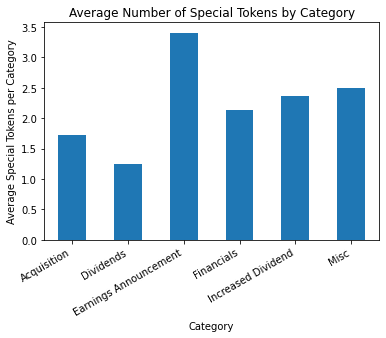

In [16]:
#Bar chart for average tokens per Category.
data.groupby('Category').special_token_length.mean().plot(kind='bar', title='Average Number of Special Tokens by Category')
plt.ylabel("Average Special Tokens per Category")
plt.xticks(rotation=30, horizontalalignment="right")
plt.show()

There does appear to be a more significant difference in the average number of special tokens in some Categories (Earnings Annoucement and Dividends). 

In [17]:
#View special tokens
special_tokens_list_of_lists = data.special_tokens.values.tolist()
special_tokens_list = [token for sublist in special_tokens_list_of_lists for token in sublist]

In [18]:
#Compute the frequency of special tokens.
spec_tokens = Counter()

for token in special_tokens_list:
    if token in spec_tokens:
        spec_tokens[token] += 1
    else:
        spec_tokens[token] = 1

In [19]:
#Number of unique special tokens in the dataset.
len(spec_tokens)

2482

There are 2,482 unique special tokens in the dataset. Most of these are different numbers.  

In [20]:
#Most common special tokens. 
spec_tokens.most_common(20)

[(',', 6332),
 ('2021', 2212),
 (':', 1856),
 ('2020', 1618),
 ('Inc.', 1505),
 ('$', 1317),
 ('.', 1140),
 ('&', 1036),
 ('(', 845),
 (')', 845),
 ('-', 792),
 ("'s", 661),
 ('Corp.', 325),
 ('100,000', 312),
 (';', 280),
 ('%', 234),
 ("'", 156),
 ('COVID-19', 128),
 ('2', 127),
 ('Full-Year', 115)]

Punctuation and years are the most common special tokens which is not a suprise. The dollar and percentage signs are also very common and could potentially be useful. 

In [21]:
#Create new columns which count the number of $ and % symbols. 
data['dollar_symbol'] = data.special_tokens.apply(lambda x: x.count('$'))
data['percentage_symbol'] = data.special_tokens.apply(lambda x: x.count('%'))

In [22]:
#View average $ special tokens per sample by category.
data.groupby('Category').dollar_symbol.mean() 

Category
Acquisition              0.158940
Dividends                0.108280
Earnings Announcement    0.000000
Financials               0.095336
Increased Dividend       0.111111
Misc                     0.124425
Name: dollar_symbol, dtype: float64

Earnings Announcement samples do not contain dollar sign symbols. The other Categories contain a simlilar amount of dollar sign symbols on average.

In [23]:
#View average % special tokens per sample by category.
data.groupby('Category').percentage_symbol.mean()

Category
Acquisition              0.052980
Dividends                0.025478
Earnings Announcement    0.000000
Financials               0.037037
Increased Dividend       0.454545
Misc                     0.013351
Name: percentage_symbol, dtype: float64

The Earnings Annoucement class has no samples containing \% symbols. The Increased Dividend class has a very high percentage of samples that include the \% symbol. 

### View Most Common NGrams 

In [24]:
#Function to create ngrams.
#Source: The generate_N_grams function is modified code from 
#https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/
def generate_N_grams(token_list, ngram=2):
  temp =zip(*[token_list[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans


#Function to display most ngrams.
def display_most_common(category, num_most_common=10, ngram=1, show_chart=True, title=None):
    """Category is a str and can be any value from the Category column of the dataset.
       num_most_common is an int and specifies the number of most common ngrams to view.
       ngram is an int and specifies the length of the ngrams.
       show_chart is a boolean and specifies is a chart of most frequent ngrams will be displayed.
    """
    
    counter = Counter()
    
    tokens = data[data.Category == category]['tokenized_text'].values.tolist() #All all samples from a specified category.
    tokens_list = [token for sublist in tokens for token in sublist]
    
    ngram_list = generate_N_grams(tokens_list, ngram=ngram) #Convert the individual tokens into ngrams.
    
    #Add ngram tokens to Counter object.
    for token in ngram_list:
        if token in counter:
            counter[token] += 1
        else:
            counter[token] = 1
            
    common_words = counter.most_common(num_most_common) #Get the most common ngrams and frequencies.
    
    #Display chart of ngram frequencies.
    if show_chart == True:
    
        df = pd.DataFrame(common_words, columns=['token', 'count'])
        df = df.set_index('token')
    
        df.plot(kind='bar', title=title, xlabel='NGrams', ylabel='Frequency')
        plt.show()
    
    return common_words
    
    
    

#### Most Common Unigrams by Category 

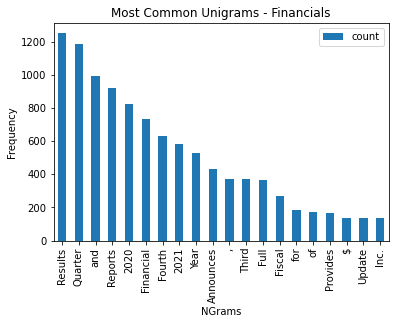

In [25]:
#Most common words for Financials class.
fin_most_common = display_most_common('Financials', 
                                      num_most_common=20, ngram=1, 
                                      title='Most Common Unigrams - Financials')

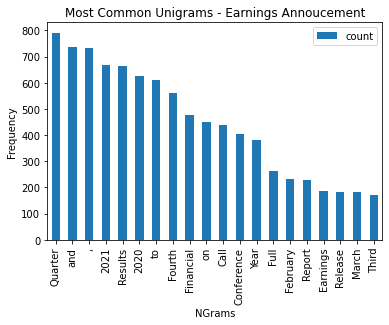

In [26]:
#Most common words for Earnings Annoucement class.
announce_most_common = display_most_common('Earnings Announcement', 
                                           num_most_common=20, ngram=1, 
                                           title='Most Common Unigrams - Earnings Annoucement')

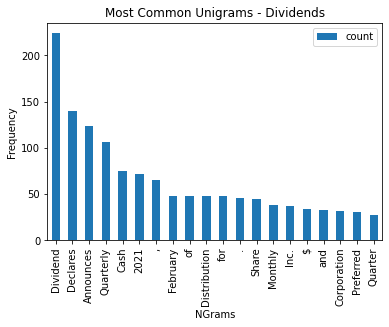

In [27]:
#Most common words for Dividends class.
div_most_common = display_most_common('Dividends', num_most_common=20, ngram=1, 
                                           title='Most Common Unigrams - Dividends')

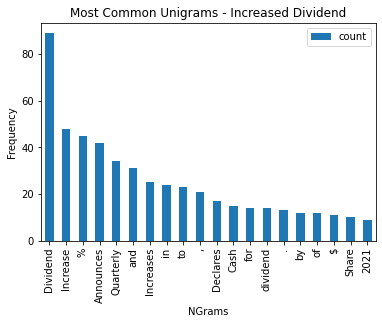

In [28]:
#Most common words for Increased Dividend class.
increase_most_common = display_most_common('Increased Dividend', num_most_common=20, ngram=1, 
                                           title='Most Common Unigrams - Increased Dividend')

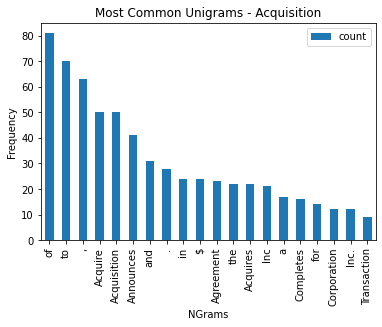

In [29]:
#Most common words for Acquisition class.
acq_most_common = display_most_common('Acquisition', num_most_common=20, ngram=1, 
                                           title='Most Common Unigrams - Acquisition')

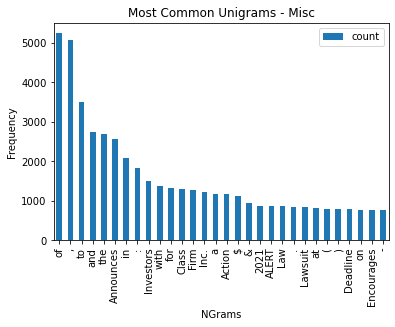

In [30]:
#Most common words for Misc class.
misc_most_common = display_most_common('Misc', num_most_common=30, ngram=1, 
                                           title='Most Common Unigrams - Misc')

#### Most Common Bigrams by Category

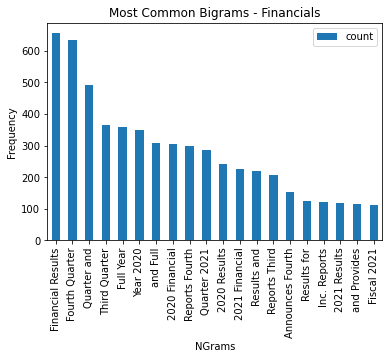

In [31]:
#Most common bigrams for Financials class.
fin_most_common = display_most_common('Financials', 
                                      num_most_common=20, ngram=2, 
                                      title='Most Common Bigrams - Financials')

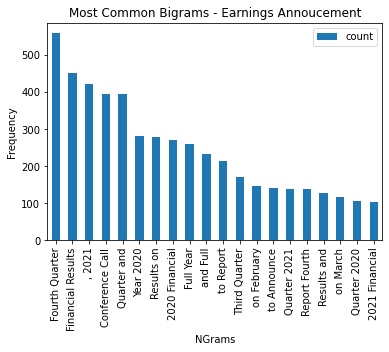

In [32]:
#Most common bigrams for Earnings Annoucement class.
announce_most_common = display_most_common('Earnings Announcement', 
                                           num_most_common=20, ngram=2, 
                                           title='Most Common Bigrams - Earnings Annoucement')

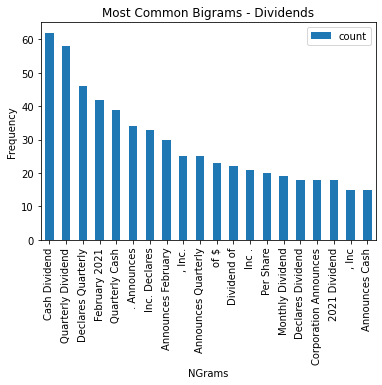

In [33]:
#Most common bigrams for Dividends class.
div_most_common = display_most_common('Dividends', num_most_common=20, ngram=2, 
                                           title='Most Common Bigrams - Dividends')

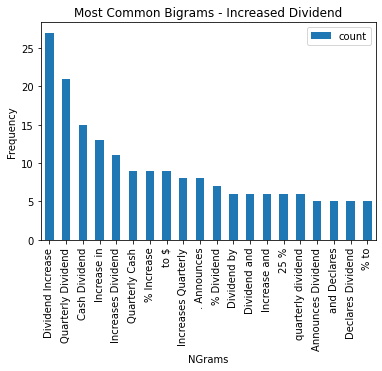

In [34]:
#Most common bigrams for Increased Dividend class.
increase_most_common = display_most_common('Increased Dividend', num_most_common=20, ngram=2, 
                                           title='Most Common Bigrams - Increased Dividend')

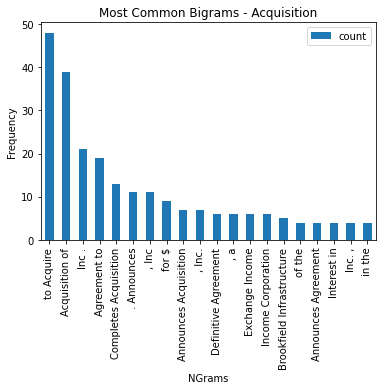

In [35]:
#Most common bigrams for Acquisition class.
acq_most_common = display_most_common('Acquisition', num_most_common=20, ngram=2, 
                                           title='Most Common Bigrams - Acquisition')

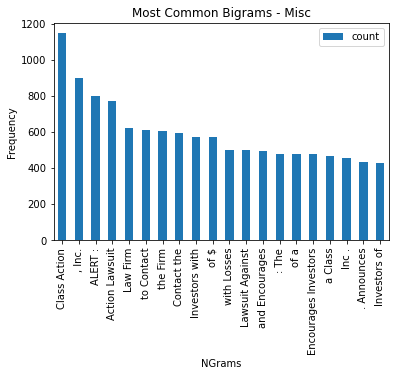

In [36]:
#Most common bigrams for Misc class.
misc_most_common = display_most_common('Misc', num_most_common=20, ngram=2, 
                                           title='Most Common Bigrams - Misc')

In [37]:
#Function to produce table with most common ngrams for all categories.
def most_common_table(ngram=1, num_most_common=10):
    """
    ngram is an int and specifies the length of the ngrams.
    num_most_common is an int and specifies the number of most common ngrams to view.
    
    Returns a dataframe containing most common ngrams for all Categories.
       
    """
    #List of Categories in data.
    categories = ['Financials', 'Earnings Announcement', 'Dividends', 'Increased Dividend', 'Acquisition', 'Misc']
    
    table_data = []
    
    #Loop through each category to get most common ngrams.
    for cat in categories:
        #Get most common ngrams dict for specified category.
        cat_words = display_most_common(cat, num_most_common=num_most_common, ngram=ngram, show_chart=False)
        words = [word for word, _ in cat_words] #Convert dict to list.
        table_data.append(words)
        
    df = pd.DataFrame(np.array(table_data).T, columns=categories) #DataFrame containing most common ngrams for all categories.
    df = df.style.set_properties(**{'text-align': 'Center', 'border': '1.3px solid black'}) #Format table
    
    
    return df
          

#### Table of Unigrams for All Categories 

In [38]:
#View most common unigrams for all categories.
most_common_table(ngram=1, num_most_common=20)

,Financials,Earnings Announcement,Dividends,Increased Dividend,Acquisition,Misc
0,Results,Quarter,Dividend,Dividend,of,of
1,Quarter,and,Declares,Increase,to,","
2,and,",",Announces,%,",",to
3,Reports,2021,Quarterly,Announces,Acquire,and
4,2020,Results,Cash,Quarterly,Acquisition,the
5,Financial,2020,2021,and,Announces,Announces
6,Fourth,to,",",Increases,and,in
7,2021,Fourth,February,in,.,:
8,Year,Financial,of,to,in,Investors
9,Announces,on,Distribution,",",$,with


#### Table of Bigrams for All Categories 

In [39]:
#View most common bigrams for all categories.
most_common_table(ngram=2, num_most_common=30)

,Financials,Earnings Announcement,Dividends,Increased Dividend,Acquisition,Misc
0,Financial Results,Fourth Quarter,Cash Dividend,Dividend Increase,to Acquire,Class Action
1,Fourth Quarter,Financial Results,Quarterly Dividend,Quarterly Dividend,Acquisition of,", Inc."
2,Quarter and,", 2021",Declares Quarterly,Cash Dividend,Inc .,ALERT :
3,Third Quarter,Conference Call,February 2021,Increase in,Agreement to,Action Lawsuit
4,Full Year,Quarter and,Quarterly Cash,Increases Dividend,Completes Acquisition,Law Firm
5,Year 2020,Year 2020,. Announces,Quarterly Cash,. Announces,to Contact
6,and Full,Results on,Inc. Declares,% Increase,", Inc",the Firm
7,2020 Financial,2020 Financial,Announces February,to $,for $,Contact the
8,Reports Fourth,Full Year,", Inc.",Increases Quarterly,Announces Acquisition,Investors with
9,Quarter 2021,and Full,Announces Quarterly,. Announces,", Inc.",of $


### Exploratory Data Analysis Discussion and Conclusions 

Average sentence length and the number of special symbols appear similar enough across the classes that they are likely of limited use for classification. 

Specific special symbols, such as the dollar and percentage sign, do show up more or less frequently in some classes. This may make them useful for classification. 

Some categories share similar words. For example, Financials and Earnings Announcement have many similar words. Financials refers to news releases that contain financial performance data while Earnings Announcement are new releases that specify that these financial reports will be released in the future. Although these classes share many words, there are a number of words that show up in the Earnings Announcement class only (such as "results on", "to report", and "will announcement") which indicate that the sample is referring to information being released on a future date. Stop words such as "on", "to", and "will" may be important features for classifying these two groups. 

Two other Categories that share many words are Dividend (which refers to the planned payment of current dividends) and Increased Dividend (which refers to the increase of the current dividend). The Increased Dividend class includes the term "increase" or "increased" more frequently and also contains the percentage sign token much more frequently. 

Using most frequent bigrams appears to increase the differences between the most similar categories (such as Financials and Earnings Announcement and Dividend and Increased Dividend). 

The class labels are highly imbalanced with the largest class (Misc) accounting for 75 percent of total samples and the smallest class Dividend Increase accounting for 0.8 percent. Undersampling the Misc class may be necessary to prevent it from dominating the classification. Validation metrics such as Precision, Recall, and F1 Score will be more appropriate than Accuracy for imbalanced classes. 

## Data Cleaning and Preprocessing 

#### Remove punctuation and symbols (keep $ and %)

In [40]:
#Check punctuation in string library
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
#Modify to retain $ and % symbols
modified_puncuation = string.punctuation.replace('$', '').replace('%', '')
modified_puncuation

'!"#&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [42]:
#Remove punctuation and symbols and create new column for preprocessed tokens
data['preprocessed_tokens'] = data.tokenized_text.apply(lambda x: [token for token in x if token not in modified_puncuation])

#### Convert text to lower case 

In [43]:
#Convert to lower case
data['preprocessed_tokens'] = data.preprocessed_tokens.apply(lambda x: [token.lower() for token in x])

#### Replace specified words 

In [44]:
#Replace words first, second, third, and fourth with [quarter]
words_to_replace = ['first', 'second', 'third', 'fourth']
data['preprocessed_tokens'] = data.preprocessed_tokens.apply(lambda x: [token if token not in words_to_replace else '[quarter]' for token in x])

In [45]:
#Replace all months of the year with [month]
months = [calendar.month_name[i].lower() for i in range(1, 12)]
data['preprocessed_tokens'] = data.preprocessed_tokens.apply(lambda x: [token if token not in months else '[month]' for token in x])

#### Remove Stopwords 

In [46]:
#Remove stopwords with the exception of the words "to" and "on".
stops = stopwords.words('english')

In [47]:
#Check that to and on were removed from stopwords list.
stops.remove('to')
stops.remove('on')
print('to' in stops)
print('on' in stops)

False
False


In [48]:
#Remove stopwords from dataset.
data['preprocessed_tokens'] = data.preprocessed_tokens.apply(lambda x: [token for token in x if token not in stops ])

In [49]:
#Check data samples.
data.preprocessed_tokens

0        [indie, semiconductor, enters, definitive, agr...
1        [virtuoso, acquisition, corp, announces, effec...
2        [dawson, geophysical, announces, merger, agree...
3        [hydrofarm, signs, agreement, to, acquire, inn...
4        [crestwood, to, acquire, oasis, midstream, par...
                               ...                        
11891    [abbott, increases, quarterly, dividend, 50th,...
11892             [autoliv, announces, dividend, increase]
11893    [cisco, raises, quarterly, dividend, 3, %, to,...
11894    [quebecor, inc, announces, 9, %, increase, qua...
11895    [taitron, announces, quarterly, cash, dividend...
Name: preprocessed_tokens, Length: 11896, dtype: object

In [50]:
data['preprocessed_tokens'][1000]

['adamas',
 'to',
 'announce',
 '[quarter]',
 'quarter',
 'year-end',
 '2020',
 'financial',
 'results',
 'host',
 'conference',
 'call',
 'on',
 '[month]',
 '23',
 '2021']

#### Replace numeric years (fourth digit numbers) with the str [year] 

In [51]:
#Replace all 4 digit numbers with [year]
data['preprocessed_tokens'] = data.preprocessed_tokens.apply(lambda x: [token if re.match(r'[0-9]{4}$', token) == None else '[year]' for token in x])

In [52]:
#Check sample
data['preprocessed_tokens'][1000]

['adamas',
 'to',
 'announce',
 '[quarter]',
 'quarter',
 'year-end',
 '[year]',
 'financial',
 'results',
 'host',
 'conference',
 'call',
 'on',
 '[month]',
 '23',
 '[year]']

#### Remove all non 4 digit numbers. 

In [53]:
#Remove all numbers that don't have 4 digits with [num]
#data['preprocessed_text'] = data.preprocessed_text.str.replace(r'[0-9]{}', '', regex=True)
data['preprocessed_tokens'] = data.preprocessed_tokens.apply(lambda x: [token for token in x if re.match(r'[0-9]+', token) == None])

In [54]:
#Check sample.
data['preprocessed_tokens'][1000]

['adamas',
 'to',
 'announce',
 '[quarter]',
 'quarter',
 'year-end',
 '[year]',
 'financial',
 'results',
 'host',
 'conference',
 'call',
 'on',
 '[month]',
 '[year]']

#### Check Most Common Unigrams Post Preprocessing 

In [55]:
#Check unigrams
most_common_table(ngram=1, num_most_common=30)

,Financials,Earnings Announcement,Dividends,Increased Dividend,Acquisition,Misc
0,Results,Quarter,Dividend,Dividend,of,of
1,Quarter,and,Declares,Increase,to,","
2,and,",",Announces,%,",",to
3,Reports,2021,Quarterly,Announces,Acquire,and
4,2020,Results,Cash,Quarterly,Acquisition,the
5,Financial,2020,2021,and,Announces,Announces
6,Fourth,to,",",Increases,and,in
7,2021,Fourth,February,in,.,:
8,Year,Financial,of,to,in,Investors
9,Announces,on,Distribution,",",$,with


#### Check Most Common Bigrams Post Preprocessing 

In [56]:
#Check bigrams
most_common_table(ngram=2, num_most_common=30)

,Financials,Earnings Announcement,Dividends,Increased Dividend,Acquisition,Misc
0,Financial Results,Fourth Quarter,Cash Dividend,Dividend Increase,to Acquire,Class Action
1,Fourth Quarter,Financial Results,Quarterly Dividend,Quarterly Dividend,Acquisition of,", Inc."
2,Quarter and,", 2021",Declares Quarterly,Cash Dividend,Inc .,ALERT :
3,Third Quarter,Conference Call,February 2021,Increase in,Agreement to,Action Lawsuit
4,Full Year,Quarter and,Quarterly Cash,Increases Dividend,Completes Acquisition,Law Firm
5,Year 2020,Year 2020,. Announces,Quarterly Cash,. Announces,to Contact
6,and Full,Results on,Inc. Declares,% Increase,", Inc",the Firm
7,2020 Financial,2020 Financial,Announces February,to $,for $,Contact the
8,Reports Fourth,Full Year,", Inc.",Increases Quarterly,Announces Acquisition,Investors with
9,Quarter 2021,and Full,Announces Quarterly,. Announces,", Inc.",of $


### Check Most Common Trigrams Post Preprocessing 

In [57]:
#Check trigrams
most_common_table(ngram=3, num_most_common=30)

,Financials,Earnings Announcement,Dividends,Increased Dividend,Acquisition,Misc
0,Fourth Quarter and,Fourth Quarter and,Quarterly Cash Dividend,Quarterly Cash Dividend,Agreement to Acquire,Class Action Lawsuit
1,and Full Year,2020 Financial Results,Announces February 2021,% Increase in,Completes Acquisition of,Contact the Firm
2,Full Year 2020,and Full Year,Declares Quarterly Dividend,% Dividend Increase,", Inc .",to Contact the
3,Reports Fourth Quarter,Quarter and Full,", Inc. Declares",Dividend Increase and,Inc . Announces,Action Lawsuit Against
4,Quarter and Full,Full Year 2020,Inc . Announces,Announces Dividend Increase,Announces Acquisition of,a Class Action
5,2020 Financial Results,Financial Results on,Dividend of $,Inc . Announces,Definitive Agreement to,Investors with Losses
6,Third Quarter 2021,Year 2020 Financial,Declares Quarterly Cash,in Quarterly Dividend,Exchange Income Corporation,and Encourages Investors
7,2021 Financial Results,Report Fourth Quarter,", Inc .",Dividend to $,Announces Agreement to,of a Class
8,Reports Third Quarter,to Report Fourth,Announces Quarterly Dividend,Announces 9 %,Castor Maritime Inc,Law Firm Announces
9,Year 2020 Financial,Third Quarter 2021,Inc. Declares Quarterly,", Inc .",Maritime Inc .,to Present at


#### Transform text tokens to str 

In [58]:
#Create new feature column preprocessed_text which converts preprocessed_tokens in single str.
data['preprocessed_text'] = data.preprocessed_tokens.apply(lambda x: " ".join(word for word in x))

In [59]:
#Check preprocessed sample.
data['preprocessed_text'][1000]

'adamas to announce [quarter] quarter year-end [year] financial results host conference call on [month] [year]'

In [60]:
#Shuffle dataset
data = data.sample(frac=1, random_state=42, ).reset_index(drop=True)
data.head()

,Category,Title,tokenized_text,text_length,special_tokens,special_token_length,dollar_symbol,percentage_symbol,preprocessed_tokens,preprocessed_text
0,Misc,SHAREHOLDER ALERT: Pomerantz Law Firm Reminds ...,"[SHAREHOLDER, ALERT, :, Pomerantz, Law, Firm, ...",25,"[:, Inc., -]",3,0,0,"[shareholder, alert, pomerantz, law, firm, rem...",shareholder alert pomerantz law firm reminds s...
1,Misc,"Rosen, A Highly Recognized Law Firm, Encourage...","[Rosen, ,, A, Highly, Recognized, Law, Firm, ,...",27,"[,, ,, 9F, Inc., -]",5,0,0,"[rosen, highly, recognized, law, firm, encoura...",rosen highly recognized law firm encourages in...
2,Misc,Albireo to Participate in Cowen and H.C. Wainw...,"[Albireo, to, Participate, in, Cowen, and, H.C...",11,[H.C.],1,0,0,"[albireo, to, participate, cowen, h.c., wainwr...",albireo to participate cowen h.c. wainwright g...
3,Misc,SHAREHOLDER ALERT: Block & Leviton LLP Has Fil...,"[SHAREHOLDER, ALERT, :, Block, &, Leviton, LLP...",27,"[:, &, ;]",3,0,0,"[shareholder, alert, block, leviton, llp, file...",shareholder alert block leviton llp filed laws...
4,Earnings Announcement,Ekso Bionics® to Report Fourth Quarter and Ful...,"[Ekso, Bionics®, to, Report, Fourth, Quarter, ...",17,"[Bionics®, 2020, 25, ,, 2021]",5,0,0,"[ekso, bionics®, to, report, [quarter], quarte...",ekso bionics® to report [quarter] quarter full...


## Feature Engineering and Selection 

#### Transform category labels to numeric values. 

In [61]:
#Convert Categories to numberic labels
label_map = {'Misc': 0, 'Earnings Announcement': 1, 'Dividends': 2, 'Increased Dividend': 3, 'Acquisition': 4, 'Financials': 5}

data['labels'] = data.Category.apply(lambda x: label_map[x])
data['labels'].describe()

count    11896.000000
mean         0.822125
std          1.689012
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: labels, dtype: float64

#### Create Training, Validation and Testing Datasets

In [62]:
#Split data

train_X, test_X, train_y, test_y = train_test_split(data, data.labels, test_size=0.3, random_state=42, stratify=data.labels)
val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, test_size=0.5,  random_state=42, stratify=test_y)

#Check sizes of train, val and test data.
print(train_X.shape)
print(train_y.shape)

print(val_X.shape)
print(val_y.shape)

print(test_X.shape)
print(test_y.shape)

(8327, 11)
(8327,)
(1784, 11)
(1784,)
(1785, 11)
(1785,)


#### Undersampling of Data in Misc Category 

The Misc class will be undersampled (remove 80% of samples). This will reduce but not eliminate the imbalance. The undersampling will be applied to the training data. The validation and testing data will retain the original class imbalance. 

In [63]:
#Remove 80% of samples in Misc category from training data.
data_subset = train_X[train_X.Category == 'Misc'].sample(frac=0.8, random_state=42)
train_X = train_X.drop(data_subset.index)

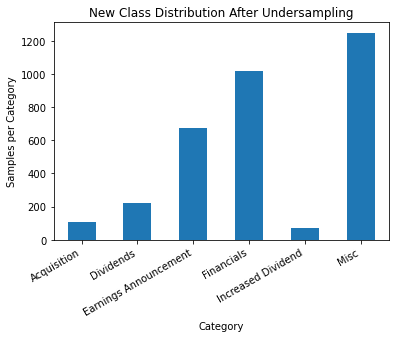

In [64]:
#Check new class distribution after undersampling.
train_X.groupby('Category').count()['preprocessed_text'].plot(kind='bar', title='New Class Distribution After Undersampling')
plt.ylabel("Samples per Category")
plt.xticks(rotation=30, horizontalalignment="right")
plt.show()

In [65]:
#Training sample counts by Category. 
train_X.groupby('Category').count()['preprocessed_text']

Category
Acquisition               106
Dividends                 220
Earnings Announcement     673
Financials               1020
Increased Dividend         69
Misc                     1248
Name: preprocessed_text, dtype: int64

After rebalancing, the number of training data samples declines from 8327 to 3336. The largest class (Misc) still accounts for 37% of the training data and the smallest class (Increased Dividend) accounts for only 2% of the training data. 

#### Transform Text Data to Count Vectors 

The input data will be count vectors with unigrams and bigrams. 

In [66]:
#Transform data samples to count vectors.

cv = CountVectorizer(ngram_range=(1, 2)) #sklearn CountVectorizer with unigrams and bigrams.

train_X_count = cv.fit_transform(train_X.preprocessed_text)
train_y = train_X.labels

val_X_count = cv.transform(val_X.preprocessed_text)
val_y = val_y.values

test_X_count = cv.transform(test_X.preprocessed_text)
test_y = test_y.values


In [67]:
#Shape of all count vectors
train_X_count.shape

(3336, 18558)

The vectorized input data consists of 18558 features (unigrams and bigrams). 

In [68]:
#Check lengths of train, val and test data.

print(train_X_count.shape)
print(val_X_count.shape)
print(test_X_count.shape)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(3336, 18558)
(1784, 18558)
(1785, 18558)
(3336,)
(1784,)
(1785,)


## Model Selection and Validation 

### Functions to View Validation Data for Models 

In [69]:
#Function to print classification/validation report with categories/labels.
def print_classification_report(true_y, preds):
    """
    true_y is array containing true values of labels.
    preds is array containing predicted values of labels.
    
    Returns
        class_report is a pandas df with validation data.
        classifcation_dict is dict with validation data.
    """
    
    #Categories of dataset.
    categories = ['Misc', 'Earnings Announcement', 'Dividends', 
                  'Increased Dividend', 'Acquisition', 'Financials']
    
    #sklearn classification report dictionary.
    classification_dict = classification_report(true_y, preds, target_names=categories, zero_division=0, output_dict=True)
    
    #Transform dict to pandas dataframe and transpose.
    class_report = pd.DataFrame(classification_dict).T
    
    return class_report, classification_dict  



def compare_models(class_report_dicts):
    """
    class_report_dict is a dict of dict containing classification / validation data dicts 
    for each model (from print_classification_report function)
    
    list_of_classifiers is a list of strs containing names of classification models used.
    
    """
    
    #Print Weighed Average Precision, Recall and F1 for all models.
    
    models = list(class_report_dicts.keys())

    score_data = []

    for model in models:
        scores = class_report_dicts[model]['weighted avg']
        index = list(scores.keys())[:-1]
        row = list(scores.values())[:-1]
        score_data.append(row)

    report = pd.DataFrame(score_data, columns=models, index=index)
    return report


#Function to print formatted sklearn confusion matrix.
def print_confusion_matrix(true_y, preds):
    """
    true_y is array containing true values of labels.
    preds is array containing predicted values of labels.
    """
    
    categories = ['Misc', 'Earnings Announcement', 'Dividends', 
                  'Increased Dividend', 'Acquisition', 'Financials']
    
    #sklearn confusion matrix
    cm = ConfusionMatrixDisplay.from_predictions(true_y, preds, 
                                                 display_labels=categories, 
                                                 xticks_rotation='vertical', cmap='gray_r', colorbar=False)
    
    return cm
    

### AdaBoost Classifier

In [70]:
#Create and Train AdaBoost Classifier and Make Predictions on Validation Set.
clf_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10, 
                                                                   min_samples_split=6),
                                                                   n_estimators=75, 
                                                                   random_state=42, 
                                                                   learning_rate=1.0).fit(train_X_count, train_y)

preds_ada = clf_ada.predict(val_X_count)

#### Adaboost Classification Report 

In [71]:
class_report_ada, class_dict_ada = print_classification_report(val_y, preds_ada)
class_report_ada

,precision,recall,f1-score,support
Misc,0.993750,0.951384,0.972105,1337.000000
Earnings Announcement,0.908497,0.965278,0.936027,144.000000
Dividends,0.781818,0.914894,0.843137,47.000000
Increased Dividend,0.857143,0.800000,0.827586,15.000000
Acquisition,0.466667,0.954545,0.626866,22.000000
Financials,0.881857,0.954338,0.916667,219.000000
accuracy,0.950673,0.950673,0.950673,0.950673
macro avg,0.814955,0.923406,0.853731,1784.000000
weighted avg,0.959901,0.950673,0.953517,1784.000000


#### Adaboost Confusion Matrix 

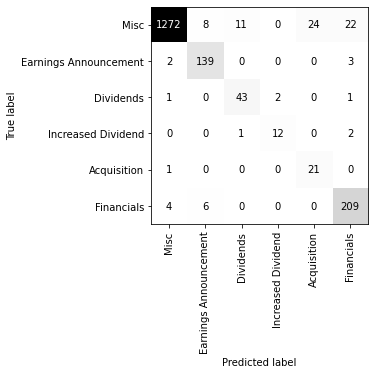

In [72]:
print_confusion_matrix(val_y, preds_ada)

### Logistic Regression 

In [73]:
##Create and Train Logistic Regression and Make Predictions on Validation Set.
log_clf = LogisticRegression(penalty='l1', multi_class='multinomial', 
                             random_state=42, solver='saga', max_iter=1500).fit(train_X_count, train_y)

preds_log = log_clf.predict(val_X_count)

#### Logistic Regression Classification Report 

In [74]:
class_report_log, class_dict_log = print_classification_report(val_y, preds_log)
class_report_log

,precision,recall,f1-score,support
Misc,0.992343,0.969334,0.980704,1337.000000
Earnings Announcement,0.907895,0.958333,0.932432,144.000000
Dividends,0.814815,0.936170,0.871287,47.000000
Increased Dividend,0.866667,0.866667,0.866667,15.000000
Acquisition,0.571429,0.909091,0.701754,22.000000
Financials,0.923423,0.936073,0.929705,219.000000
accuracy,0.961883,0.961883,0.961883,0.961883
macro avg,0.846095,0.929278,0.880425,1784.000000
weighted avg,0.966142,0.961883,0.963266,1784.000000


#### Logistic Regression Confusion Matrix  

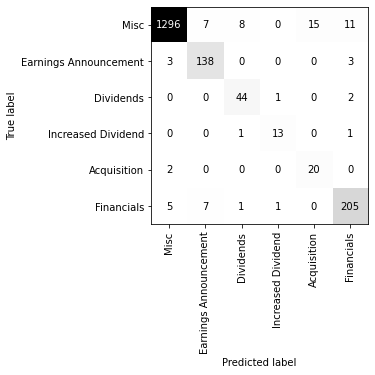

In [75]:
print_confusion_matrix(val_y, preds_log)

### Support Vector Machine 

In [76]:
##Create and Train Support Vector Machine and Make Predictions on Validation Set.
svc_clf = SVC(C=1.0, kernel='linear', random_state=42, decision_function_shape='ovo').fit(train_X_count, train_y)

preds_svc = svc_clf.predict(val_X_count)

#### Support Vector Machine Classification Report 

In [77]:
class_report_svc, class_dict_svc = print_classification_report(val_y, preds_svc)
class_report_svc

,precision,recall,f1-score,support
Misc,0.990129,0.975318,0.982668,1337.000000
Earnings Announcement,0.914474,0.965278,0.939189,144.000000
Dividends,0.758621,0.936170,0.838095,47.000000
Increased Dividend,0.909091,0.666667,0.769231,15.000000
Acquisition,0.680000,0.772727,0.723404,22.000000
Financials,0.927602,0.936073,0.931818,219.000000
accuracy,0.963565,0.963565,0.963565,0.963565
macro avg,0.863319,0.875372,0.864068,1784.000000
weighted avg,0.965742,0.963565,0.964115,1784.000000


#### Support Vector Machine Confusion Matrix  

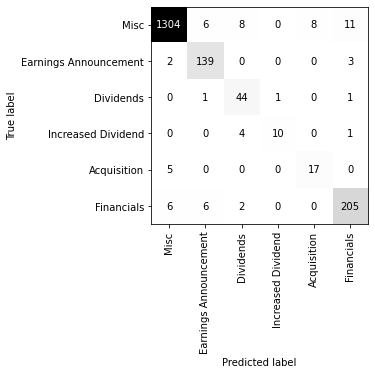

In [78]:
print_confusion_matrix(val_y, preds_svc)

### Compare Model Performance

In [79]:
#Comparison Performance of Models
class_report_dicts = {'AdaBoost': class_dict_ada, 'Logistic Regression': class_dict_log, 'Support Vector': class_dict_svc}

compare_models(class_report_dicts)

,AdaBoost,Logistic Regression,Support Vector
precision,0.959901,0.950673,0.953517
recall,0.966142,0.961883,0.963266
f1-score,0.965742,0.963565,0.964115


All 3 of the models perform reasonably well with precision, recall and f1 scores all above 95%.

AdaBoost outperforms Logistic Regression and Support Vector Classification on precision, recall and f1 by a small margin. 

AdaBoost performs particularly well on the classes that would contain the most useful information (Financials, Acquisitions, and Increased Dividend). AdaBoost correctly classifies 94.5% of the validation samples in these 3 classes compared to 93.0% for Logistic Regression and 90.6% for Support Vector Classification.  

## Model Selection and Testing

##### AdaBoost will be selected as the final model for testing. 

In [80]:
#AdaBoost Performance on Test Set
test_preds = clf_ada.predict(test_X_count)

In [81]:
#Classification report for final model (AdaBoost)
class_report_ada_test, _ = print_classification_report(test_y, test_preds)
class_report_ada_test

,precision,recall,f1-score,support
Misc,0.989028,0.943904,0.965940,1337.000000
Earnings Announcement,0.889610,0.951389,0.919463,144.000000
Dividends,0.733333,0.936170,0.822430,47.000000
Increased Dividend,0.764706,0.866667,0.812500,15.000000
Acquisition,0.428571,0.782609,0.553846,23.000000
Financials,0.898305,0.968037,0.931868,219.000000
accuracy,0.944538,0.944538,0.944538,0.944538
macro avg,0.783926,0.908129,0.834341,1785.000000
weighted avg,0.954038,0.944538,0.947632,1785.000000


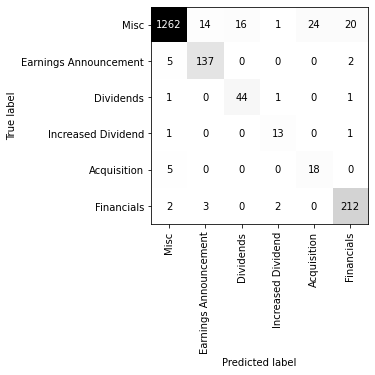

In [82]:
#Confusion Matrix for Final model
print_confusion_matrix(test_y, test_preds)

The performance of the AdaBoost classifier on the test set was comparable (although slightly lower) to the performance on the validation data. 

The AdaBoost classifier correctly classified 94.5% of the testing samples in the 3 categories of greatest interest (Financials, Acquisition, and Increased Dividend).

## Feature Importances 

In [83]:
#Function to display chart or table of most important features in model. 

def display_feature__importances(num_top_features=20, output='chart'):
    """
    num_top_features is an int which specifies the number of top feature importances to display.
    output is a str (chart, table) which specifies if the output will be a chart or a table.
    
    Returns chart or table of feature importances.
    """
    
    df = pd.DataFrame(clf_ada.feature_importances_, columns=['Importance']) #Feature importances from model in pandas df format.
    df = df.sort_values('Importance', ascending=False).head(num_top_features) #Sort feature importances descending.
    
    word_idxs = df.index.values #Get index values for features which will correspond to indices in count vec vocabulary.
    
    cv_vocab = cv.vocabulary_ #CountVectorizer vocabulary dict.
    vocab_importance_map = {cv_vocab[key]: key for key in cv_vocab} #Invert dict some vocab can be retrieved by index.
    
    #Pandas df of vocab terms and indices from CountVectorizer
    importance_words = pd.DataFrame([vocab_importance_map[idx] for idx in word_idxs],
                                     index=word_idxs, columns=['Terms'])
    
    df['Terms'] = importance_words #Add words/features to corresponding importance values. 
    
    #Output results as either bar chart or table.
    if output == 'chart':
        title = 'Top %s Features' % (num_top_features)
        return df.plot('Terms', kind='barh', figsize=(8, num_top_features/4), title=title).invert_yaxis()
    
    elif output == 'table':
        return df  

#### Display Most Importance Features 

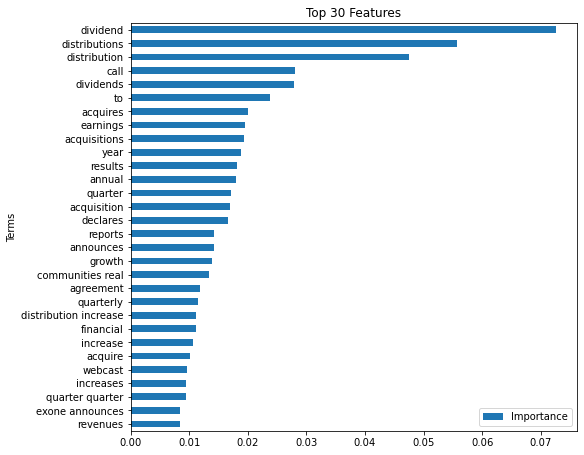

In [89]:
#Top 30 Features
display_feature__importances(num_top_features=30)

The feature importances are largely as expected. Most of the terms in the top 30 features are financial terms related to the categories (such as dividend, acquires, distribution increase, revenues, etc.). Few relavant bigrams made the list of most important features. 

## Financial News Classifier App 

The make_prediction function below can be used to test the trained classifier on new data. This function could be used in an API or application that would classify news release headlines (inputed as raw text) into 1 of the categories. 

In [85]:
#Text Preprocessing Function

def preprocess_text(text):
    """
    text is a str that will be preprocessed and count vectorized for classification.
    Returns a count vector representing the input text.
    """
    tokens = word_tokenize(text) #Word Tokenize str.
    tokens = [token for token in tokens if token not in modified_puncuation] #Remove punctuation.
    tokens = [token.lower() for token in tokens] #Convert to lower case.
    tokens = [token if token not in words_to_replace else '[quarter]' for token in tokens] #Replace select words.
    tokens = [token if token not in months else '[month]' for token in tokens] #Replace select words.
    tokens = [token for token in tokens if token not in stops] #Remove stopwords.
    tokens = [token if re.match(r'[0-9]{4}$', token) == None else '[year]' for token in tokens] #Covert 4 digits numbers to str [year]
    tokens = [token for token in tokens if re.match(r'[0-9]+', token) == None] #Remove all non 4 digit numbers.
    text_processed = " ".join(word for word in tokens) #Combine list of tokens into str.
    
    count_vector = cv.transform([text_processed]) #Transform str into count vector.
    
    return count_vector
    
    

### Prediction Function 

In [86]:
#Function to classify raw input text.

def make_prediction(text):
    """
    text is a str which the function will preprocess and classify.
    Returns the prediction for the category that the text belongs to. 
    """
    count_vector = preprocess_text(text) #Preprocess raw text into count vector.
    
    pred = clf_ada.predict(count_vector)[0] #Make prediction.
    
    #Dict to map numeric prediction to Category.
    class_map = {0: 'Misc', 1: 'Earnings Announcement', 2: 'Dividends', 
                 3: 'Increased Dividend', 4: 'Acquisition', 5: 'Financials'}
    
    return class_map[pred]
    
    

#### Experiment with different text strings (financial news headlines) to see how the model classifies new samples. 

In [87]:
#Test prediction function.
text = 'Prince Acquisition Corp. Completes IPO'

make_prediction(text)

'Misc'

In [88]:
#SAMPLE NEWS RELEASE HEADLINES TO TEST

#VALUE LINE, INC. ANNOUNCES A 13.6% INCREASE IN ITS QUARTERLY CASH DIVIDEND TO $0.25 PER COMMON SHARE; 8TH CONSECUTIVE INCREASE
#Bank of the James Announces First Quarter 2022 Financial Results and Declaration of Dividend
#METROCITY BANKSHARES, INC. REPORTS EARNINGS FOR FIRST QUARTER 2022
#Premier Health Completes the Previously Announced Acquisition of Canadian Health Care Agency
#Prince International Corporation Completes Acquisition of Ferro Corporation
#Modiv Completes $56 Million Acquisition of Industrial Sale Leaseback Portfolio
#Cavco Industries Announces Closing of Acquisition of Manufacturing Facility in North Carolina, Expanding Affordable Home Production Capabilities
#SPAC Global Blockchain Acquisition Corp. Files for IPO
#SHUAA Partners Acquisition Corp I Announces the Separate Trading of its Class A Ordinary Shares and Warrants, Commencing April 22, 2022

## Final Analysis and Conclusions 

The dataset consists of 11,896 samples of financial news headlines with each sample labelled as 1 of 6 classes/categories (Financials, Acquisition, Increased Dividend, Dividend, Earnings Announcement, and Misc). The Categories are highly imbalanced with the largest category (Misc) accounting for 75% of the data and the smallest category (Increased Dividend) accounting for 0.8% of the data.

The final model generates multi-class, classifications of samples into one of the 6 categories. Classifying financial news release headlines can help financial analysts and investors focus on important information (Financials, Acquisition, and Increased Dividend) and filter out noise (Dividend, Earnings Announcement and Misc). 

Exploratory data analysis indicated that certain special tokens ($ and \%) and certain stop words ("on", "to", and "will") would likely be useful features to retain. Unigram and bigrams appeared to differentiate the categories and would likely be useful for classification. Trigrams contained several company names which could overfit the model. Sentence length and number of special tokens did not appear to provide good features for classification. 

Standard text preprocessing was conducted including removal of punctuation and symbols (with the exception of the $ and \% signs), conversion to lower case, normalization of certain word groups, removal of stop words (with the exception of "on", "to", and "will") and removal of most numeric values. The text samples were transformed to count vectors consisting of unigrams and bigrams.  

Training (70%), validation (15%) and testing (15%) datasets were created. The testing data was not used until the final model and all hyperparameters were selected. Undersampling was performed on the training set (not the validation and testing sets) with the removal of 80% of the Misc category samples. This reduced the number of training samples from 8327 to 3336. The class remained highly imbalanced. 

Three classification algorithms were tested and compared on the training and validation data (AdaBoost, Logistic Regression and Support Vector). These algorithms were chosen because they are standard, widely used, classification techniques that represent a range of approaches to the classification problem. Hyperparameter tuning was conducted to optimize each model’s performance on the validation set. 

All there models performed well on the validation set. Precision, recall and f1 score were used as validation metrics which was appropriate for the unbalanced classes. AdaBoost did outperform the other two models (although marginally) on precision, recall and f1. AdaBoost performed particularly well on classifying the 3 categories of greatest interest (Financials, Acquisition and Increased Dividend). 

AdaBoost was selected as the final model and performed well on the testing set with precision of 95.4%, recall of 94.5% and an f1 score of 94.5%. The final model also correctly classified 94.5% of test samples from the Financials, Acquisition and Increased Dividend categories. The performance was impressive, especially considering the class imbalance of the categories and the small number of training samples in the Increased Dividend and Acquisition classes. 

Feature importances of the final model were visualized. Most of the top terms were related to the financial categories were expected to be useful for classification. There were a small number of relevant bigrams in the top 30 features. 

Two functions were created (preprocess_text and make_prediction) to test the final model on new financial news headlines. These functions can also be used to power an application which could classify and filter a live stream of news headlines. 

There are a number of different steps that could be taken to further improve the model. 
* Add more data to better balance the classes and increase the number of training samples in the smaller categories (Increased Dividend and Acquisition). 
* Experimenting with additional models (including deep learning and gradient boosting). 
* Performing hyperparameter tuning with GridSearchCV.
* Experimenting with other feature engineering techniques (including TFIDF, word2vec, and doc2vec).
